In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision.datasets import FashionMNIST

In [2]:
# text encoding
class InputEmbedding(nn.Module):
    def __init__(self, d_model, vocab_size):
        super(InputEmbedding, self).__init__()
        self.embedding= nn.Embedding(vocab_size, d_model)

    def forward(self, x):
        return self.embedding(x)

class ImagePatching(nn.Module):
    def __init__(self, image_size, patch_size, in_channels, embed_dim):
        super(ImagePatching, self).__init__()
        self.projection= nn.Conv2d(in_channels, embed_dim, kernel_size= patch_size, stride= patch_size)
    
    ## what transformation happens here:
    ## lets say we pass an input image batch of shape: [batch_size, input_channels, Height, Width]
    ## then finally transforms it into: [batch_size, (image_size//patch_size)**2, d_model]
    def forward(self, x): 
        x= self.projection(x) 
        x= x.flatten(2)
        return x.transpose(-2, -1) 

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len, dropout):
        super(PositionalEncoding, self).__init__()

        pe= torch.zeros(max_len, d_model)

        for i in range(max_len):
            for j in range(d_model):
                if j%2==0:
                    pe[i][j]= np.sin(i/ (10000** (j/d_model)))
                else:
                    pe[i][j]= np.cos(i/(10000** ((j-1)/d_model)))
        self.register_buffer("pe", pe.unsqueeze(0))

        self.dropout= nn.Dropout(dropout)
    def forward(self, x):
        x= x+ self.pe
        return x

In [3]:
class AttentionHead(nn.Module):
    def __init__(self, embed_dim, head_size):
        super(AttentionHead, self).__init__()
        self.head_size= head_size
        self.query= nn.Linear(embed_dim, head_size)
        self.key= nn.Linear(embed_dim, head_size)
        self.value= nn.Linear(embed_dim, head_size)

    def forward(self, x, mask=None):
        Q= self.query(x)
        K= self.key(x)
        V= self.value(x)

        attention= Q@K.transpose(-2, -1)
        attention= attention/(self.head_size**0.5)

        if mask is not None:
            attention= attention.masked_fill(mask==0, float("-inf"))
        attention= torch.softmax(attention, dim=-1)

        attention= attention@V
        return attention
        

In [4]:
class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim, nheads):
        super().__init__()
        self.head_size= embed_dim//nheads
        self.W_o= nn.Linear(embed_dim, embed_dim)
        self.attentionblocks= nn.ModuleList([AttentionHead(embed_dim, self.head_size) for _ in range(nheads)])

    def forward(self, x, mask= None):
        out= torch.cat([head(x, mask) for head in self.attentionblocks] ,dim =-1)
        out= self.W_o(out)
        return out

In [5]:
class TransformerEncoder(nn.Module):
    def __init__(self, d_model, nheads, r_mlp=4):
        super().__init__()
        self.norm1= nn.LayerNorm(d_model)
        self.mha= MultiHeadAttention(d_model, nheads)
        self.mlp= nn.Sequential(
            nn.Linear(d_model, d_model*r_mlp),
            nn.GELU(),
            nn.Linear(d_model* r_mlp, d_model)
        )
        self.norm2= nn.LayerNorm(d_model)

    def forward(self, x, mask=None):
        x= x+ self.mha(self.norm1(x), mask)
        x= x+ self.mlp(self.norm2(x))
        return x

In [6]:
class ImageEncoder(nn.Module):
    def __init__(self, width, image_size, patch_size, in_channels, n_layers,nheads, embed_dim, dropout=0.1):
        super(ImageEncoder, self).__init__()
        assert (image_size[0] % patch_size[0]==0) and (image_size[1] % patch_size[1]==0), "image_size dim shall be divisible by patchsize"
        assert width%nheads==0, "width shall be divisible by nheads"
        
        self.image_embedding= ImagePatching(image_size, patch_size, in_channels, width)
        self.npatches= (image_size[0]*image_size[1]) // (patch_size[0]*patch_size[1])
        self.cls_token= nn.Parameter(torch.randn(1,1, width))

        self.positional_embedding= PositionalEncoding(width, self.npatches+1, dropout)
        self.encoder= nn.ModuleList([TransformerEncoder(width, nheads) for _ in range(n_layers)])

        self.projection= nn.Parameter(torch.randn(width ,embed_dim))

    def forward(self, x):
        x= self.image_embedding(x)
        #print(x.shape, self.cls_token.shape)
        x= torch.cat([self.cls_token.expand(x.size()[0], -1, -1), x], dim=1)
        x= self.positional_embedding(x)

        for encoder in self.encoder:
            x= encoder(x)

        x= x[:, 0, :]

        if self.projection is not None:
            x= x@self.projection

        x= x/torch.norm(x, dim=-1, keepdim=True)
        return x

In [7]:
class TextEncoder(nn.Module):
    def __init__(self, vocab_size, width, max_seq_length, n_heads, n_layers, emb_dim):
        super().__init__()

        self.max_seq_length = max_seq_length

        self.encoder_embedding = nn.Embedding(vocab_size, width)

        self.positional_embedding = PositionalEncoding(width, max_seq_length, 0.1)

        self.encoder = nn.ModuleList([TransformerEncoder(width,n_heads) for _ in range(n_layers)])

        # learned proj of image to embed
        self.projection = nn.Parameter(torch.randn(width, emb_dim))

    def forward(self, text, mask=None):
        # Text Embedding
        x = self.encoder_embedding(text)

        # Positional Embedding
        x = self.positional_embedding(x)

        # Transformer Encoder
        for encoder_layer in self.encoder:
            x = encoder_layer(x, mask=mask)

        # Takes features from the EOT Embedding
        x = x[torch.arange(text.shape[0]), torch.sub(torch.sum(mask[:,0],dim=1),1)]

        # joint multimodal embedding
        if self.projection is not None:
            x = x @ self.projection

        x = x / torch.norm(x, dim=-1, keepdim=True)

        return x

In [22]:
# model

class CLIP(nn.Module):
    def __init__(self, emb_dim, vit_width, img_size, patch_size, n_channels, vit_layers, vit_heads, vocab_size, text_width, max_seq_length, text_heads, text_layers):
        super().__init__()

        self.image_encoder = ImageEncoder(vit_width, img_size, patch_size, n_channels, vit_layers, vit_heads, emb_dim)
        
        self.text_encoder = TextEncoder(vocab_size, text_width, max_seq_length, text_heads, text_layers, emb_dim)
        self.temperature = nn.Parameter(torch.ones([]) * np.log(1/0.07))
        self.device= torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def forward(self, image,text, mask=None):
        i_encode= self.image_encoder(image)
        t_encode= self.text_encoder(text, mask)
        #print(i_encode.shape, t_encode.shape)
        logits= (i_encode @ t_encode.T)/ torch.exp(self.temperature)
        #labels= torch.arange(logits.shape[0]).to(self.device)

        return logits

        #loss_i= nn.functional.cross_entropy(logits, labels)
        #loss_t= nn.functional.cross_entropy(logits.transpose(-2, -1), labels)

        #loss= (loss_i+loss_t)/2
        #return loss
        

In [11]:
def tokenizer(text, encode=True, mask=None, max_seq_length=32):
    if encode:
        out = chr(2) + text + chr(3) # Adding SOT and EOT tokens
        out = out + "".join([chr(0) for _ in range(max_seq_length-len(out))]) # Adding Padding
        out = torch.IntTensor(list(out.encode("utf-8"))) # Encoding Text
        mask = torch.ones(len(out.nonzero()))
        mask = torch.cat((mask,torch.zeros(max_seq_length-len(mask)))).type(torch.IntTensor)
    else:
        out = [chr(x) for x in text[1:len(mask.nonzero())-1]]
        out = "".join(out)
        mask = None

    return out, mask 

In [15]:
class PrepareDS(Dataset):
    def __init__(self, img_size, train=True):
        #self.dataset = load_dataset("fashion_mnist")
        
        self.transform= T.Compose([T.Resize(img_size), 
                                   T.ToTensor()
                        ])
        self.dataset= FashionMNIST(
            root='./data', 
            train=train, 
            download=True
        )
        if train:
            self.split="train"
        else:
            self.split= "test"

        self.captions = {0: "An image of a t-shirt/top",
                        1: "An image of trousers",
                        2: "An image of a pullover",
                        3: "An image of a dress",
                        4: "An image of a coat",
                        5: "An image of a sandal",
                        6: "An image of a shirt",
                        7: "An image of a sneaker",
                        8: "An image of a bag",
                        9: "An image of an ankle boot"}

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img= self.dataset[idx][0]
        
        img= self.transform(img)

        cap, mask= tokenizer(self.captions[self.dataset[idx][1]])
        mask= mask.repeat(len(mask), 1)

        return {"image": img, "caption": cap, "mask":mask}

In [16]:
emb_dim = 32
vit_width = 9
img_size = (28,28)
patch_size = (14,14)
n_channels = 1
vit_layers = 3
vit_heads = 3
vocab_size = 256
text_width = 32
max_seq_length = 32
text_heads = 8
text_layers = 4
lr = 1e-3
epochs = 10
batch_size = 128


In [17]:
train_set= PrepareDS(img_size, train=True)
test_set= PrepareDS(img_size, train=False)

train_dataloader= DataLoader(train_set, shuffle=True, batch_size= batch_size)
test_dataloader= DataLoader(test_set, shuffle=False, batch_size= 32)

In [55]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device: ", device, f"({torch.cuda.get_device_name(device)})" if torch.cuda.is_available() else "")

model = CLIP(emb_dim, vit_width, img_size, patch_size, n_channels, vit_layers, vit_heads, vocab_size, text_width, max_seq_length, text_heads, text_layers).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
from tqdm import tqdm

best_loss = np.inf
for epoch in range(epochs):
    model.train()
    for data in tqdm(train_dataloader):
        img, cap, mask = data["image"].to(device), data["caption"].to(device), data["mask"].to(device)
        logits= model(img,cap,mask)
        #labels_image= torch.arange(logits.shape[0]).to(device)
        labels_text= torch.arange(logits.shape[1]).to(device)
        image_to_text= nn.functional.cross_entropy(logits, labels_text)
        text_to_image= nn.functional.cross_entropy(logits.transpose(-2, -1), labels_text)
        loss= (image_to_text + text_to_image)/2
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{epochs}], Batch Loss: {loss.item():.3f}")

    # Saves model if it performed better than the previous best
    if loss.item() <= best_loss:
        best_loss = loss.item()
        torch.save(model.state_dict(), "clip.pt")
        print("Model Saved.")

Using device:  cuda (NVIDIA GeForce GTX 1650)


100%|█████████████████████████████████████████| 469/469 [00:27<00:00, 17.12it/s]


Epoch [1/10], Batch Loss: 4.453
Model Saved.


100%|█████████████████████████████████████████| 469/469 [00:28<00:00, 16.37it/s]


Epoch [2/10], Batch Loss: 4.366
Model Saved.


100%|█████████████████████████████████████████| 469/469 [00:29<00:00, 15.66it/s]


Epoch [3/10], Batch Loss: 4.132
Model Saved.


100%|█████████████████████████████████████████| 469/469 [00:29<00:00, 15.80it/s]


Epoch [4/10], Batch Loss: 3.775
Model Saved.


100%|█████████████████████████████████████████| 469/469 [00:29<00:00, 15.77it/s]


Epoch [5/10], Batch Loss: 3.362
Model Saved.


100%|█████████████████████████████████████████| 469/469 [00:29<00:00, 15.81it/s]


Epoch [6/10], Batch Loss: 2.855
Model Saved.


100%|█████████████████████████████████████████| 469/469 [00:29<00:00, 15.76it/s]


Epoch [7/10], Batch Loss: 2.773
Model Saved.


100%|█████████████████████████████████████████| 469/469 [00:29<00:00, 15.74it/s]


Epoch [8/10], Batch Loss: 2.772
Model Saved.


100%|█████████████████████████████████████████| 469/469 [00:29<00:00, 15.88it/s]


Epoch [9/10], Batch Loss: 2.584
Model Saved.


100%|█████████████████████████████████████████| 469/469 [00:30<00:00, 15.58it/s]

Epoch [10/10], Batch Loss: 2.787


In [214]:
batch= next(iter(train_dataloader))

s= batch["image"]
image_embedding= ImageEmbedding(1, (28, 28),(14, 14), 32)
image_= image_embedding(s)
image_.shape

torch.Size([128, 4, 32])

In [301]:
print(type(test_set[0]["index"]))

<class 'int'>


In [126]:
cls_token= torch.cat([torch.randn(1,1,32).expand(image_.size()[0], -1, -1),image_], dim=1)

In [128]:
cls_token.shape

torch.Size([128, 5, 32])

In [29]:
a= torch.tensor([[1, 1, 0], 
                 [1, 2, 1]])

b= torch.tensor([[0, 2, 1], 
                 [1, 1, 1]])

torch.eq(a, b)

tensor([[False, False, False],
        [ True, False,  True]])

In [64]:
## for testing purpose
#text= torch.stack([tokenizer(x)[0] for x in test_set.captions.values()]).to(device) ## [10, 32]
#mask= torch.stack([tokenizer(x)[1] for x in test_set.captions.values()]).to(device)
#mask= mask.repeat(1, len(mask[0])).reshape(len(mask), len(mask[0]),len(mask[0])).to(device)

#image= torch.stack([x for x in test_set.image.values]
##print(text.shape, mask.shape)
image_stack= torch.stack([image["image"] for image in test_set]).to(device)
correct, total= 0, 0
model.eval()
with torch.no_grad():
    for data in tqdm(test_dataloader):
        _,text, mask= data["image"].to(device), data["caption"].to(device), data["mask"].to(device)
        
        image_features= model.image_encoder(image_stack) ## convert to shape: [batch, emb_dim] ==> [32, 32]
        text_features= model.text_encoder(text, mask) ## convert to shape: [len(test_set), emb_dim] ==> [32, 32]

        
        ##image_features /= image_features.norm(dim=-1, keepdim=True) ## [10000,32]
        ##text_features /= text_features.norm(dim=-1, keepdim=True) ## [32,32]

        
        similarity= (100* text_features @ image_features.T).softmax(dim=-1) ## [32, 10000] 
        #print(similarity.shape)
        _, indices= torch.max(similarity, 1) ## [32]
        
        pred= torch.stack([test_set[int(i)]["caption"] for i in indices]).to(device) ## [32, 32]
        #print(pred.shape)
        print(f"Pred and label: {pred.shape}, {text.shape}") 
        correct+= int(sum(torch.sum((pred==text), dim=1)//len(pred[0])))
        
        total+= len(text)

    print(f"\nModel Accuracy: {100* correct//total}%")

  1%|▌                                          | 4/313 [00:00<00:19, 16.22it/s]

Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])


  3%|█                                          | 8/313 [00:00<00:17, 17.81it/s]

Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])


  4%|█▌                                        | 12/313 [00:00<00:16, 18.30it/s]

Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])


  5%|██▏                                       | 16/313 [00:00<00:16, 18.50it/s]

Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])


  6%|██▋                                       | 20/313 [00:01<00:15, 18.61it/s]

Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])


  8%|███▏                                      | 24/313 [00:01<00:15, 18.56it/s]

Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])


  9%|███▊                                      | 28/313 [00:01<00:15, 18.58it/s]

Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])


 10%|████▎                                     | 32/313 [00:01<00:15, 18.64it/s]

Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])


 12%|████▊                                     | 36/313 [00:01<00:14, 18.71it/s]

Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])


 13%|█████▎                                    | 40/313 [00:02<00:14, 18.70it/s]

Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])


 14%|█████▉                                    | 44/313 [00:02<00:14, 18.70it/s]

Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])


 15%|██████▍                                   | 48/313 [00:02<00:14, 18.68it/s]

Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])


 17%|██████▉                                   | 52/313 [00:02<00:14, 18.50it/s]

Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])


 18%|███████▌                                  | 56/313 [00:03<00:13, 18.64it/s]

Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])


 19%|████████                                  | 60/313 [00:03<00:13, 18.71it/s]

Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])


 20%|████████▌                                 | 64/313 [00:03<00:13, 18.65it/s]

Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])


 22%|█████████                                 | 68/313 [00:03<00:13, 18.68it/s]

Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])


 23%|█████████▋                                | 72/313 [00:03<00:12, 18.77it/s]

Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])


 24%|██████████▏                               | 76/313 [00:04<00:12, 18.64it/s]

Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])


 26%|██████████▋                               | 80/313 [00:04<00:12, 18.69it/s]

Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])


 27%|███████████▎                              | 84/313 [00:04<00:12, 18.65it/s]

Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])


 28%|███████████▊                              | 88/313 [00:04<00:12, 18.69it/s]

Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])


 29%|████████████▎                             | 92/313 [00:04<00:11, 18.84it/s]

Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])


 31%|████████████▉                             | 96/313 [00:05<00:11, 18.62it/s]

Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])


 32%|█████████████                            | 100/313 [00:05<00:11, 18.55it/s]

Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])


 33%|█████████████▌                           | 104/313 [00:05<00:11, 18.50it/s]

Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])


 35%|██████████████▏                          | 108/313 [00:05<00:11, 18.62it/s]

Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])


 36%|██████████████▋                          | 112/313 [00:06<00:10, 18.65it/s]

Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])


 37%|███████████████▏                         | 116/313 [00:06<00:10, 18.34it/s]

Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])


 38%|███████████████▋                         | 120/313 [00:06<00:10, 18.55it/s]

Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])


 40%|████████████████▏                        | 124/313 [00:06<00:10, 18.63it/s]

Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])


 41%|████████████████▊                        | 128/313 [00:06<00:09, 18.68it/s]

Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])


 42%|█████████████████▎                       | 132/313 [00:07<00:09, 18.66it/s]

Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])


 43%|█████████████████▊                       | 136/313 [00:07<00:09, 18.74it/s]

Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])


 45%|██████████████████▎                      | 140/313 [00:07<00:09, 18.79it/s]

Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])


 46%|██████████████████▊                      | 144/313 [00:07<00:09, 18.75it/s]

Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])


 47%|███████████████████▍                     | 148/313 [00:07<00:08, 18.72it/s]

Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])


 49%|███████████████████▉                     | 152/313 [00:08<00:08, 18.62it/s]

Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])


 50%|████████████████████▍                    | 156/313 [00:08<00:08, 18.44it/s]

Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])


 51%|████████████████████▉                    | 160/313 [00:08<00:08, 18.62it/s]

Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])


 52%|█████████████████████▍                   | 164/313 [00:08<00:07, 18.64it/s]

Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])


 54%|██████████████████████                   | 168/313 [00:09<00:07, 18.71it/s]

Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])


 55%|██████████████████████▌                  | 172/313 [00:09<00:07, 18.67it/s]

Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])


 56%|███████████████████████                  | 176/313 [00:09<00:07, 18.66it/s]

Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])


 58%|███████████████████████▌                 | 180/313 [00:09<00:07, 18.68it/s]

Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])


 59%|████████████████████████                 | 184/313 [00:09<00:06, 18.61it/s]

Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])


 60%|████████████████████████▋                | 188/313 [00:10<00:06, 18.60it/s]

Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])


 61%|█████████████████████████▏               | 192/313 [00:10<00:06, 18.60it/s]

Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])


 63%|█████████████████████████▋               | 196/313 [00:10<00:06, 18.73it/s]

Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])


 64%|██████████████████████████▏              | 200/313 [00:10<00:06, 18.63it/s]

Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])


 65%|██████████████████████████▋              | 204/313 [00:10<00:05, 18.62it/s]

Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])


 66%|███████████████████████████▏             | 208/313 [00:11<00:05, 18.53it/s]

Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])


 68%|███████████████████████████▊             | 212/313 [00:11<00:05, 18.73it/s]

Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])


 69%|████████████████████████████▎            | 216/313 [00:11<00:05, 18.73it/s]

Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])


 70%|████████████████████████████▊            | 220/313 [00:11<00:04, 18.78it/s]

Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])


 72%|█████████████████████████████▎           | 224/313 [00:12<00:04, 18.76it/s]

Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])


 73%|█████████████████████████████▊           | 228/313 [00:12<00:04, 18.71it/s]

Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])


 74%|██████████████████████████████▍          | 232/313 [00:12<00:04, 18.48it/s]

Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])


 75%|██████████████████████████████▉          | 236/313 [00:12<00:04, 18.60it/s]

Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])


 77%|███████████████████████████████▍         | 240/313 [00:12<00:03, 18.59it/s]

Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])


 78%|███████████████████████████████▉         | 244/313 [00:13<00:03, 18.66it/s]

Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])


 79%|████████████████████████████████▍        | 248/313 [00:13<00:03, 18.74it/s]

Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])


 81%|█████████████████████████████████        | 252/313 [00:13<00:03, 18.79it/s]

Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])


 82%|█████████████████████████████████▌       | 256/313 [00:13<00:03, 18.76it/s]

Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])


 83%|██████████████████████████████████       | 260/313 [00:13<00:02, 18.73it/s]

Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])


 84%|██████████████████████████████████▌      | 264/313 [00:14<00:02, 18.74it/s]

Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])


 86%|███████████████████████████████████      | 268/313 [00:14<00:02, 18.44it/s]

Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])


 87%|███████████████████████████████████▋     | 272/313 [00:14<00:02, 18.57it/s]

Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])


 88%|████████████████████████████████████▏    | 276/313 [00:14<00:02, 18.49it/s]

Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])


 89%|████████████████████████████████████▋    | 280/313 [00:15<00:01, 18.50it/s]

Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])


 91%|█████████████████████████████████████▏   | 284/313 [00:15<00:01, 18.38it/s]

Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])


 92%|█████████████████████████████████████▋   | 288/313 [00:15<00:01, 18.05it/s]

Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])


 93%|██████████████████████████████████████▏  | 292/313 [00:15<00:01, 18.28it/s]

Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])


 95%|██████████████████████████████████████▊  | 296/313 [00:15<00:00, 18.49it/s]

Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])


 96%|███████████████████████████████████████▎ | 300/313 [00:16<00:00, 18.18it/s]

Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])


 97%|███████████████████████████████████████▊ | 304/313 [00:16<00:00, 18.51it/s]

Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])


 98%|████████████████████████████████████████▎| 308/313 [00:16<00:00, 18.81it/s]

Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])


100%|████████████████████████████████████████▊| 312/313 [00:16<00:00, 18.81it/s]

Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])
Pred and label: torch.Size([32, 32]), torch.Size([32, 32])


100%|█████████████████████████████████████████| 313/313 [00:16<00:00, 18.59it/s]

Pred and label: torch.Size([16, 32]), torch.Size([16, 32])

Model Accuracy: 100%


In [272]:
test_set[0]["image"].unsqueeze(0).shape

torch.Size([1, 1, 28, 28])

In [281]:
a= torch.tensor([1, 0, 1]) 
b= torch.tensor([1, 0, 0])

torch.sum(a==b, dim=0)

tensor(2)

In [ ]:
a= torch.tensor([1, 1,1])
b= torch.tensor([1, 0, 1])

print(a)
print(b)

sum(torch.sum(a==b, dim=0))

In [321]:
text_= "shirt"
tokens, mask= tokenizer(text_)


(tensor([  2, 115, 104, 105, 114, 116,   3,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0], dtype=torch.int32),
 tensor([1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0], dtype=torch.int32))

In [328]:
torch.cuda.empty_cache()

In [108]:
text_= "shirt"
mask= mask.repeat(len(mask), 1)
text_, mask= tokenizer(text_)
mask= mask.unsqueeze(0)
print(mask.shape)
mask= mask.repeat(len(mask), 1)
print(text_.unsqueeze(0).shape)
print(mask.shape)
text__= model.text_encoder(text__.unsqueeze(0).to(device), mask= mask.unsqueeze(0).to(device))
text__.shape

RuntimeError: Number of dimensions of repeat dims can not be smaller than number of dimensions of tensor

In [ ]:
mask_= mask.unsqueeze(0).to(device)
print(mask_.shape)
torch.sum(mask_[:, 0], dim=1)

In [83]:
batch= next(iter(test_dataloader))

text= batch["caption"]
mask= batch["mask"]
#text_, mask_= tokenizer(text)
print(text.shape, mask.shape)

text_= model.text_encoder(text.to(device), mask= mask.to(device))
print(text_.shape)

torch.Size([32, 32]) torch.Size([32, 32, 32])
torch.Size([32, 32])


In [52]:
model = CLIP(emb_dim, vit_width, img_size, patch_size, n_channels, vit_layers, vit_heads, vocab_size, text_width, max_seq_length, text_heads, text_layers).to(device)
model.load_state_dict(torch.load("clip.pt", map_location=device))
def retrieve_images(query):
    query_text, query_mask = tokenizer(query)
    query_text = query_text.unsqueeze(0).to(device)  # Add batch dimension
    query_mask = query_mask.unsqueeze(0)
    query_mask= query_mask.repeat(len(query_mask[0]), 1).unsqueeze(0).to(device)

    
    with torch.no_grad():
        query_features = model.text_encoder(query_text, mask=query_mask)
        #query_features /= query_features.norm(dim=-1, keepdim=True)
 
    # Step 2: Encode all images in the dataset and store features
    image_features_list = []
    image_paths = []
 
    #val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=5)
    
    with torch.no_grad():
        for batch in test_dataloader:
            images = batch["image"].to(device)
            features = model.image_encoder(images)
            #features /= features.norm(dim=-1, keepdim=True)
 
            image_features_list.append(features)
            # Assuming batch contains image paths or IDs
 
    # Concatenate all image features
    image_features = torch.cat(image_features_list, dim=0)
 
    # Step 3: Compute similarity using the CLIP model's logic
    similarities = (query_features @ image_features.T) * torch.exp(
        model.temperature
    )
    similarities = similarities.softmax(dim=-1)
 
    # Retrieve top 20 matches
    _, top_indices = similarities[0].topk(5)
    print(type(top_indices))
    print(top_indices)
    # Step 4: Retrieve and display top N images
    return top_indices
    images_to_display = []
    for index in top_indices:
        img_path = test_set[int(index)]["image"]
        print(f"Type: {type(img_path)}")
        out_img2= img_path.detach().numpy()
        arr_ = out_img2.squeeze
        plt.imshow(arr_)
        plt.show()
        #images_to_display.append(np.array(img))
        #img.show()
        #plt.axis("off")
        #plt.show()
    

/tmp/ipykernel_9943/1390394696.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("clip.pt", map_location=device))


In [53]:
res= retrieve_images("shirt")

<class 'torch.Tensor'>
tensor([ 612, 2986,  926, 8197, 5135], device='cuda:0')


In [123]:
for i in range(len(test_set)):
    print(type(test_set[i]["image"]))
    break

<class 'torch.Tensor'>


In [140]:
print(res)

tensor([6120, 4251, 1357, 2059,  684], device='cuda:0')


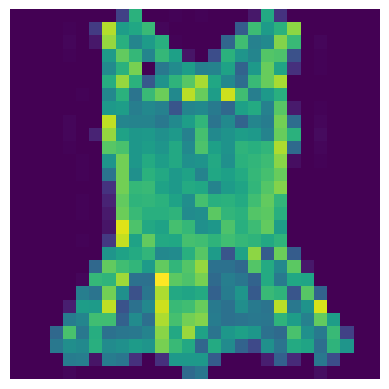

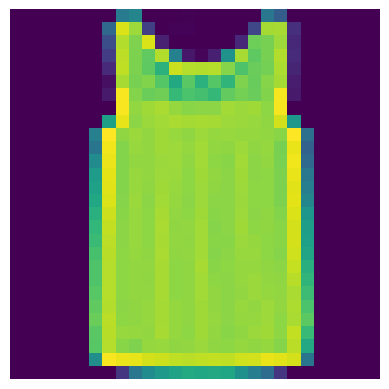

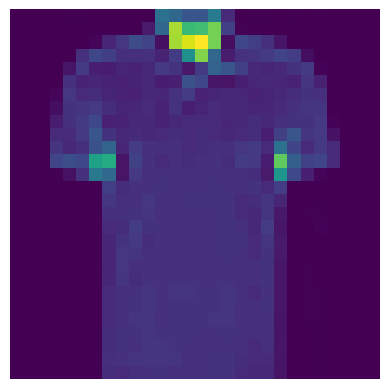

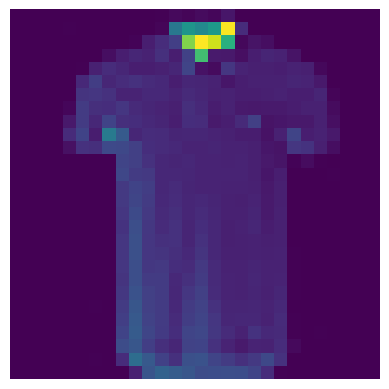

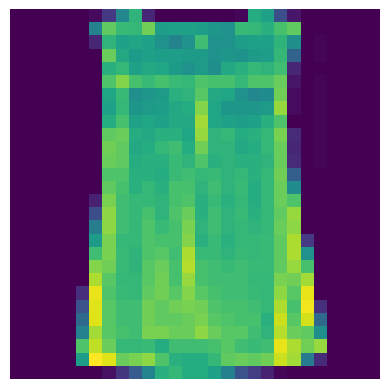

In [54]:
for i in res:
    image_= test_set[int(i)]["image"].permute(1, 2, 0).numpy()
    plt.imshow(image_)
    plt.axis("off")
    plt.show()
    

In [73]:
model = CLIP(emb_dim, vit_width, img_size, patch_size, n_channels, vit_layers, vit_heads, vocab_size, text_width, max_seq_length, text_heads, text_layers).to(device)
model.load_state_dict(torch.load("clip.pt", map_location=device))

def top_products(query):
    query_text, query_mask = tokenizer(query)
    query_text = query_text.unsqueeze(0).to(device)  # Add batch dimension
    query_mask = query_mask.unsqueeze(0)
    query_mask= query_mask.repeat(len(query_mask[0]), 1).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        text_encoded= model.text_encoder(query_text, query_mask)

        ## get the image 
        image_features= torch.cat([batch["image"] for batch in test_dataloader], dim=0).to(device)
        image_features= model.image_encoder(image_features)

        

        similarity= (text_encoded@ image_features.T)*torch.exp(model.temperature)
        similarity= similarity.softmax(dim=-1)

        _, top_indices= similarity[0].topk(5)

        return top_indices

/tmp/ipykernel_9943/2220428050.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("clip.pt", map_location=device))


tensor([8499, 2230, 2867, 9840, 2907], device='cuda:0')


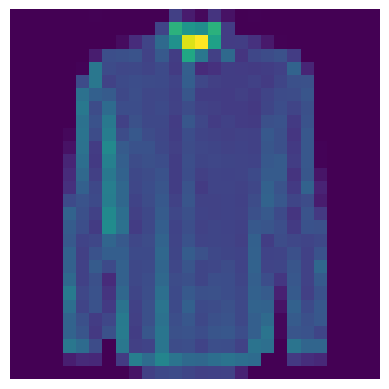

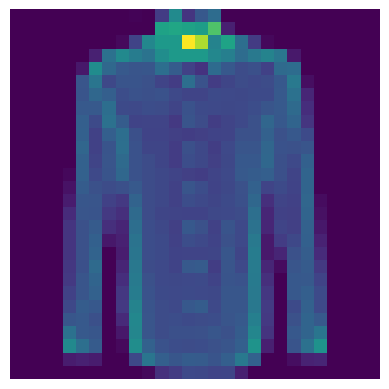

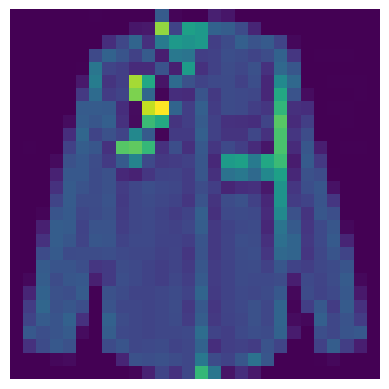

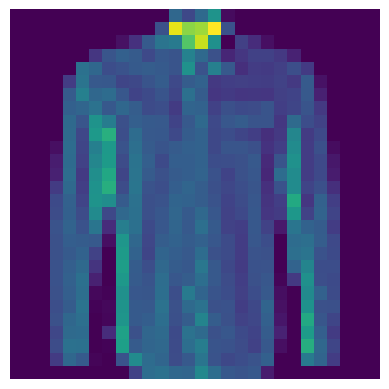

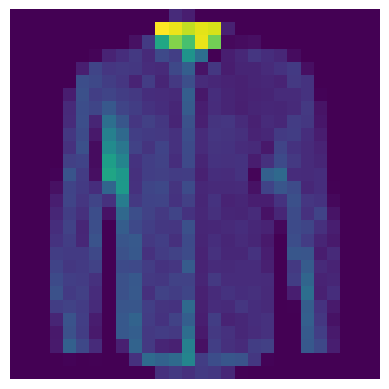

In [77]:
res= top_products("shirt")

print(res)
for i in res:
    image_= test_set[int(i)]["image"].permute(1, 2, 0).numpy()
    plt.imshow(image_)
    plt.axis("off")
    plt.show()

In [67]:
image_features= []

for batch in test_dataloader:
    images= batch["image"].to(device)
    features= model.image_encoder(images)
    image_features.append(features)

image_features= torch.cat(image_features, dim=0)
image_features.shape

torch.Size([10000, 32])

In [70]:
image_features= torch.cat([batch["image"] for batch in test_dataloader], dim=0)
image_features= model.image_encoder(image_features.to(device))
image_features.shape

torch.Size([10000, 32])